In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import scipy.stats as stats
import math as math

pd.options.mode.chained_assignment = None

In [2]:
file_names = ['..\\PhD_data\\BH06\\BH06_raw_round1-infusions.xlsx',
              '..\\PhD_data\\BH06\\BH06_raw_round1-makeup.xlsx',
              '..\\PhD_data\\BH06\\BH06_raw_round2-infusions.xlsx']

group_names = {0:'lOFC',
               1:'PrL'} 

lOFC = [1,2,3,4,5,6,8,9,11,12,13,14,15,16,24,25,26,32]

PrL = [18,19,20,21,22,23,27,28,29,30,31]

groups = [lOFC, PrL]



In [8]:
def load_data(fnames): 
#load data from computer
    for i,file in enumerate(fnames):
        if i == 0:
            df = pd.read_excel(fnames[i])
        else:
            df2 = pd.read_excel(fnames[i])
            df = df.append(df2, ignore_index = True)
    return df

def check_groups(df):
    pd.set_option('display.max_rows', None)
    print(df.groupby(['Subject','Group'])['Trial'].max())
    pd.set_option('display.max_rows',df.Subject.max())
    
def get_choices(df):
    #set up option column with correct P1 to P4 configuration for version A and B
    configA = np.array([1, 4, 0, 2, 3])
    configB = np.array([4, 1, 0, 3, 2])

    df['option'] = df['MSN'].str.contains("B").values*configB[df['Chosen'].astype('int').ravel()-1].astype('int') + \
        df['MSN'].str.contains("A").values*configA[df['Chosen'].astype('int').ravel()-1].astype('int')

    #fix zeros
    for i in range(len(df)):
        if df['Chosen'][i] == 0:
            df['option'][i] = 0
    return df
    
def get_sum_choice(num, df, mode):
    #get choice information for given group number or session number
    df1 = df.loc[df[mode] == num]
    subs = df1.Subject.unique()
    subs.sort()
    percentage = pd.DataFrame(columns=[str(num) + 'P1',str(num) + 'P2',str(num) + 'P3',str(num) + 'P4'])
    for sub in subs:
        for i,column in enumerate(percentage.columns):
            percentage.at[sub,column] = (len(df1.loc[(df1.option == i + 1) & 
                                            (df1.Subject == sub)]))/(len(df1.loc[(df1['option'] != 0) & 
                                                                                (df.Subject == sub)])) *100
    return percentage

def get_sum_choice_all(df, mode):
    df_sess = []
    for num in np.sort(df[mode].unique()):
        df_sess.append(get_sum_choice(num,df,mode))
    df1 = pd.concat(df_sess, axis=1)
    for num in np.sort(df[mode].unique()):
        df1['risk'+ str(num)] = df1[str(num)+'P1'] + df1[str(num)+'P2']- df1[str(num)+'P3'] - df1[str(num)+'P4']
    return df1

def get_premature(df_raw,df_sum,mode):
    #extract premature response information on either group or session
    prem_resp = df_raw.groupby(['Subject', mode],as_index=False)['Premature_Resp'].sum()

    prem_resp['Trials'] = df_raw.groupby(['Subject',mode],as_index=False)['Trial'].count()['Trial']

    prem_resp['prem_percent'] = prem_resp['Premature_Resp']/prem_resp['Trials'] * 100

    for num in np.sort(df_raw[mode].unique()):
        df_sum['prem' + str(num)] = prem_resp.loc[prem_resp[mode]==num].set_index('Subject')['prem_percent']
    return df_sum
    
    
def get_latencies(df_raw,df_sum,mode):
    #extract collect and choice lat information
    df_raw = df_raw.loc[df_raw['Chosen'] != 0]
    collect_lat = df_raw.groupby(['Subject',mode],as_index=False)['Collect_Lat'].mean()
    choice_lat = df_raw.groupby(['Subject',mode],as_index=False)['Choice_Lat'].mean()
    for num in np.sort(df_raw[mode].unique()):
        df_sum['collect_lat' + str(num)] = collect_lat.loc[collect_lat[mode]==num].set_index('Subject')['Collect_Lat']
    for num in np.sort(df_raw[mode].unique()):
        df_sum['choice_lat' + str(num)] = choice_lat.loc[choice_lat[mode]==num].set_index('Subject')['Choice_Lat']
    return df_sum


def get_omit(df_raw,df_sum,mode):
    omit = df_raw.groupby(['Subject',mode],as_index=False)['Omit'].sum()
    for num in np.sort(df_raw[mode].unique()):
        df_sum['omit' + str(num)] = omit.loc[omit[mode]==num].set_index('Subject')['Omit']
    return df_sum

def get_trials(df_raw,df_sum,mode):
    trials = df_raw.groupby(['Subject', mode],as_index=False)['Trial'].max()
    for num in np.sort(df_raw[mode].unique()):
        df_sum['trial' + str(num)] = trials.loc[trials[mode]==num].set_index('Subject')['Trial']
    return df_sum

def get_trials_init(df_raw,df_sum,mode):
    trials = df_raw.groupby(['Subject',mode],as_index=False)['Trial'].count()
    for num in np.sort(df_raw[mode].unique()):
        df_sum['trial_init' + str(num)] = trials.loc[trials[mode]==num].set_index('Subject')['Trial']
    return df_sum

def get_summary_data(df_raw, mode='Session'):
    df_raw = get_choices(df_raw)
    df_sum = get_sum_choice_all(df_raw,mode)
    df_sum = get_latencies(df_raw,df_sum,mode)
    df_sum = get_omit(df_raw,df_sum,mode)
    df_sum = get_trials(df_raw,df_sum,mode)
    df_sum = get_premature(df_raw,df_sum,mode)
    return df_sum
    
def get_group_means_sem(df_sum,groups, group_names):
    dfs = []
    for group in groups:
        dfs.append(df_sum.loc[group])
    avg_scores = pd.DataFrame(columns=list(df_sum.columns))
    avg_stderror = pd.DataFrame(columns=avg_scores.columns)
    for column in avg_scores.columns:
        for i in range(len(groups)):
            avg_scores.at[i,column] = dfs[i][column].mean()
            avg_stderror.at[i,column] = stats.sem(dfs[i][column])
            
    avg_scores.rename(index=group_names,inplace = True)
    avg_stderror.rename(index=group_names, inplace = True)
    return avg_scores, avg_stderror

def get_risk_status_vehicle(df1):
    #get risk status from 'risk1' only - ie in the case of LS, the saline dose
    #create lists for indexing based on risk score
    risky = []
    optimal = []
    for sub in df1.index:
        if df1.at[sub,'risk1'] > 0:
            df1.at[sub,'risk_status'] = 1
            optimal.append(sub)
        elif df1.at[sub,'risk1'] < 0:
            df1.at[sub,'risk_status'] = 2
            risky.append(sub)
    return df1, risky, optimal

def choice_bar_plot(startsess, endsess, scores, sem,cmap = 'default'):
    sess = list(range(startsess,endsess + 1))
    labels = ['P1','P2','P3','P4']
    df = pd.DataFrame()
    df1 = pd.DataFrame()
    if cmap == 'Paired':
        colors = [plt.cm.Paired(5),plt.cm.Paired(1),plt.cm.Paired(4),plt.cm.Paired(0)]
    if cmap == 'default':
        colors = [plt.cm.Set1(1),plt.cm.Set1(0)]
    for choice in labels:
        df[choice] = scores.loc[:, [col for col in scores.columns if choice in col 
                                    and int(col[:col.index('P')]) in sess]].mean(axis = 1)
        df1[choice] = sem.loc[:, [col for col in scores.columns if choice in col 
                                    and int(col[:col.index('P')]) in sess]].mean(axis = 1)
    ax = df.transpose().plot.bar(rot = 0, yerr = df1.transpose(), capsize = 8, figsize = (20,8))
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    plt.rcParams.update({'font.size': 18})
    ax.set_ylabel('% Choice', fontweight = 'bold', fontsize = 18)
    ax.set_title('P1-P4 Choice', fontweight = 'bold', fontsize = 22, pad = 20)
    ax.set_ylim(bottom = 0)
    ax.spines['right'].set_linewidth(0)
    ax.spines['top'].set_linewidth(0)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.legend()
    
def ls_bar_plot(figure_group, group_means, sem):
    labels = ['P1','P2','P3','P4']
    veh_means =  list(group_means.loc[figure_group,[col for col in group_means.columns if col.startswith('1')]])
    dose1_means = list(group_means.loc[figure_group,[col for col in group_means.columns if col.startswith('2')]])
    dose2_means = list(group_means.loc[figure_group,[col for col in group_means.columns if col.startswith('3')]])
    dose3_means = list(group_means.loc[figure_group,[col for col in group_means.columns if col.startswith('4')]])

    x = np.arange(len(labels))*3  # the label locations
    width = 0.5  # the width of the bars

    fig, ax = plt.subplots(figsize = (10,5))
    rects1 = ax.bar(x - width/2-width, veh_means, width, label='Vehicle',
                    yerr = list(sem.loc[figure_group,[col for col in sem.columns if col.startswith('1')]]), capsize = 8, ecolor='C0')
    rects2 = ax.bar(x - width/2, dose1_means, width, label='Dose 1', 
                    yerr =list(sem.loc[figure_group,[col for col in sem.columns if col.startswith('2')]]), capsize = 8, ecolor='C1')
    rects3 = ax.bar(x + width/2, dose2_means, width, label='Dose 2',
                    yerr = list(sem.loc[figure_group,[col for col in sem.columns if col.startswith('3')]]),capsize = 8, ecolor='C3',color = 'C3')
    rects4 = ax.bar(x + width/2+width, dose3_means, width, label='Dose 3',capsize = 8, 
                    yerr = list(sem.loc[figure_group,[col for col in sem.columns if col.startswith('4')]]), ecolor='C2', color = 'C2')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('% Choice', fontweight = 'bold', fontsize = 22)
    ax.set_title(figure_group + ': P1-P4', fontweight = 'bold', fontsize = 24, pad = 20)
    ax.set_ylim(bottom = 0,top = 85)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.spines['right'].set_linewidth(0)
    ax.spines['top'].set_linewidth(0)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.legend()
    
def rgt_plot(variable,startsess,endsess,group_names,title,scores,sem,cmap = 'default', highlight = None, var_title = None):
    if var_title == None:
        var_title = variable
    plt.rcParams.update({'font.size': 18})
    fig,ax = plt.subplots(figsize = (15,8))
    ax.set_ylabel(var_title, fontweight='bold', fontsize = 22)
    ax.set_xlabel('Session', fontweight = 'bold', fontsize = 22)
    ax.set_title(title + ': ' + var_title + '\n' + 'Baseline session ' + str(startsess) + '-' + str(endsess),
                fontweight = 'bold', fontsize = 22, pad = 20)
    ax.spines['right'].set_linewidth(0)
    ax.spines['top'].set_linewidth(0)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    x=np.arange(startsess,endsess+1)
    if cmap == 'Paired':
        colors = [plt.cm.Paired(5),plt.cm.Paired(1),plt.cm.Paired(4),plt.cm.Paired(0)]
    if cmap == 'default':
        colors = [plt.cm.Set1(1),plt.cm.Set1(0)]
   
    for i,group in enumerate(group_names.values()):
        y = scores.loc[group,variable+str(startsess):variable+str(endsess)]
        plt.errorbar(x, y,
                     yerr = sem.loc[group,variable+str(startsess):variable+str(endsess)], 
                     label=group,linewidth=5, capsize = 8)
    if highlight != None:
        plt.axvline(highlight, 0, 1, color = 'gray', lw = 1)
        ax.fill_between([highlight,endsess], ax.get_ylim()[0], ax.get_ylim()[1], facecolor='gray', alpha=0.2)
    ax.legend()
    ax.set_xticks(np.arange(startsess,endsess+1))
    
    
def export_to_excel(df,groups,groupname,filename, asin = False):
#save specified number of sessions as excel file
    dfs = []
    for group in groups:
        dfs.append(df.loc[group])
    for i,df in enumerate(dfs):
        df[groupname] = i
    df_export = pd.concat(dfs)
    if asin:
        col_list = [col for col in df.columns if 'P' in col] + [col for col in df.columns if 'prem' in col]
        for col in col_list:
            for sub in df_export.index:
                df_export.at[sub,col] = np.arcsin(math.sqrt(df_export.at[sub,col]/100))
    df_export.sort_index(inplace = True)
    df_export.to_excel(filename, index_label = 'Subject')
    
# def reload_data(fname, groupname, groupnames):
#     #read in previously created file and set lists for indexing 
#     df1 = pd.read_csv(fname)
#     df1.set_index('Subject',inplace=True)
#     groups = 
#     for group in groupnames:
#         for sub in df1.index:
#             if df1.loc[sub,groupname] == group:
#                 groups[0].append(sub)
#     risky = []
#     optimal = []
#     for sub in df1.index:
#         if df1.loc[sub,'risk_status'] == 1:
#             optimal.append(sub)
#         else:
#             risky.append(sub)
#     return df1, risky, optimal
    


In [9]:
#read in excel file
df = load_data(file_names)

In [10]:
#check group labels
check_groups(df)

Subject  Group
1        1         50.1
         2         79.1
         3         40.0
         4        111.0
2        1         77.0
         2         74.0
         3         70.0
         4         94.0
3        1         50.1
         2         38.1
         3         45.0
         4         40.0
4        1         86.0
         2         82.0
         3         95.0
         4         79.0
5        0         87.0
         1         79.1
         2         79.0
         4        128.0
6        1        125.1
         2         98.0
         3        105.0
         4        121.0
7        1         76.1
         2         80.1
         3         68.0
         4         57.1
8        1         75.0
         2         58.0
         3         57.1
         4         66.0
9        1         65.1
         2         69.0
         3         55.0
         4         48.0
11       1         56.1
         2         58.0
         3         61.0
         4         55.0
12       1         63.0
 

In [6]:
#subject 5 data for dose 3 didn't get labelled in the group column
for i in range(len(df)):
    if df.at[i,'Subject'] == 5 and df.at[i,'Group']  == 0:
        df.at[i,'Group'] = 3

In [7]:
#get summary data
df1 = get_summary_data(df,mode= 'Group')


In [8]:
#fill in missing data


,1P1,1P2,1P3,1P4,2P1,2P2,2P3,2P4,3P1,3P2,...,omit3,omit4,trial1,trial2,trial3,trial4,prem1,prem2,prem3,prem4
1,0,34,64,2,0,57.1429,35.0649,7.79221,5,40,...,0,2,50.1,79.1,40.0,111.0,54.954955,32.478632,70.588235,14.615385
2,3.8961,59.7403,7.79221,28.5714,12.3288,61.6438,6.84932,19.1781,8.57143,45.7143,...,0,1,77.0,74.0,70.0,94.0,23.000000,28.846154,31.372549,17.543860
3,0,18,78,4,0,13.8889,80.5556,5.55556,2.22222,20,...,0,0,50.1,38.1,45.0,40.0,57.264957,70.400000,64.000000,56.989247
4,1.23457,67.9012,0,30.8642,1.21951,65.8537,0,32.9268,0,77.6596,...,1,2,86.0,82.0,95.0,79.0,24.561404,21.904762,16.666667,15.957447
5,5.12821,35.8974,55.1282,3.84615,3.84615,61.5385,28.2051,6.41026,17.4419,40.6977,...,1,0,79.1,79.0,87.0,128.0,33.898305,41.044776,21.621622,19.496855
6,1.62602,85.3659,0,13.0081,2.06186,72.1649,0,25.7732,1.90476,69.5238,...,0,0,125.1,98.0,105.0,121.0,13.888889,15.517241,10.256410,1.626016
7,5.33333,62.6667,16,16,21.25,58.75,2.5,17.5,7.35294,58.8235,...,0,0,76.1,80.1,68.0,57.1,42.307692,40.740741,50.000000,52.892562
8,4,44,0,52,6.89655,31.0345,5.17241,56.8966,0,42.8571,...,0,0,75.0,58.0,57.1,66.0,18.478261,42.574257,47.169811,41.071429
9,0,1.5625,98.4375,0,0,14.9254,82.0896,2.98507,1.85185,11.1111,...,1,2,65.1,69.0,55.0,48.0,26.436782,24.175824,46.078431,54.716981
11,3.63636,1.81818,94.5455,0,1.72414,3.44828,93.1034,1.72414,1.63934,4.91803,...,0,0,56.1,58.0,61.0,55.0,35.294118,31.764706,11.594203,29.487179


In [10]:
group_means, sem = get_group_means_sem(df1,groups, group_names)
group_means

,1P1,1P2,1P3,1P4,2P1,2P2,2P3,2P4,3P1,3P2,...,omit3,omit4,trial1,trial2,trial3,trial4,prem1,prem2,prem3,prem4
lOFC,3.30642,45.3488,40.024,11.3208,5.35821,45.9962,36.3361,12.3095,4.05441,50.1433,...,0.388889,0.944444,75.3778,77.9118,75.6278,83.6333,28.6188,29.8219,31.9009,25.9226
PrL,8.3455,39.3302,30.9188,21.4055,4.38031,45.8537,30.9322,18.8338,4.49606,43.7692,...,1.18182,0.909091,64.21,73.3727,75.4091,78.6636,36.9707,31.9367,28.6367,24.1903


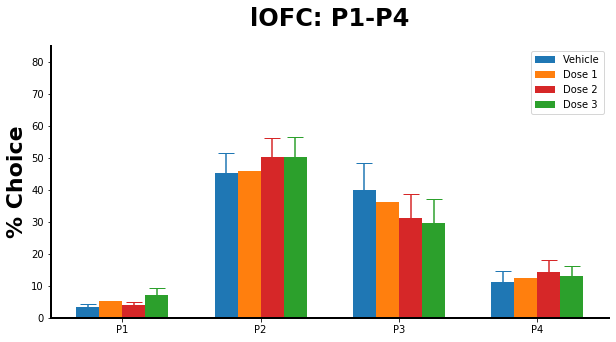

In [11]:
ls_bar_plot('lOFC',group_means,sem)

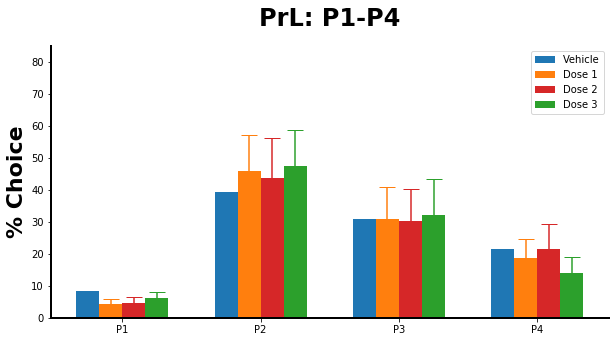

In [12]:
ls_bar_plot('PrL',group_means,sem)

In [11]:
df1,risky,optimal = get_risk_status_vehicle(df1)

lOFC_risky = [value for value in lOFC if value in risky]
lOFC_optimal = [value for value in lOFC if value in optimal]
PrL_risky = [value for value in PrL if value in risky]
PrL_optimal = [value for value in PrL if value in optimal]

groups_risk = [lOFC_risky,lOFC_optimal,PrL_risky,PrL_optimal]
group_names_risk = {0: 'lOFC risky',1: 'lOFC optimal', 2:'PrL risky', 3: 'PrL optimal'}

group_means_risk, sem_risk = get_group_means_sem(df1,groups_risk,
                                                group_names_risk)

group_means_risk

,1P1,1P2,1P3,1P4,2P1,2P2,2P3,2P4,3P1,3P2,...,omit4,trial1,trial2,trial3,trial4,prem1,prem2,prem3,prem4,risk_status
lOFC risky,1.83757,23.3235,66.9189,7.92001,2.94912,28.7905,57.7121,10.5483,4.69806,28.695,...,1.44444,59.8333,62.0333,63.0222,69.3556,37.0639,37.9668,37.2271,33.6114,2
lOFC optimal,4.77526,67.3741,13.1291,14.7215,8.06845,65.3527,12.288,14.2908,3.41077,71.5917,...,0.444444,90.9222,95.775,88.2333,97.9111,20.1736,20.6589,26.5747,18.2338,1
PrL risky,10.2661,14.7385,43.0823,31.913,5.05203,17.0825,49.9446,27.9209,6.2982,9.87437,...,0.833333,51.6833,51.6667,52.4,54.7,39.2102,37.0913,31.6966,24.9612,2
PrL optimal,5.46456,76.2177,12.6736,5.64416,4.27551,75.8586,10.1467,9.7192,2.72747,81.1219,...,1.25,83,90.775,95.025,99.275,33.6114,30.7804,27.1687,26.5175,1


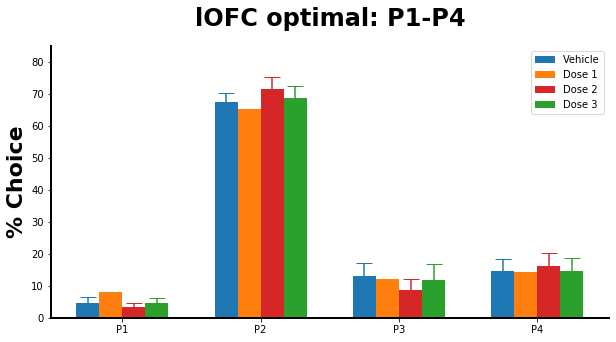

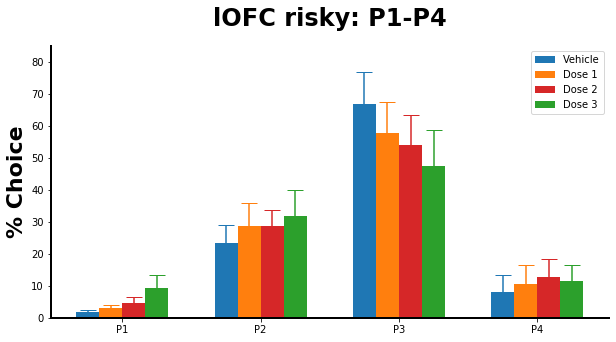

In [12]:
ls_bar_plot('lOFC optimal',group_means_risk,sem_risk)
ls_bar_plot('lOFC risky',group_means_risk,sem_risk)

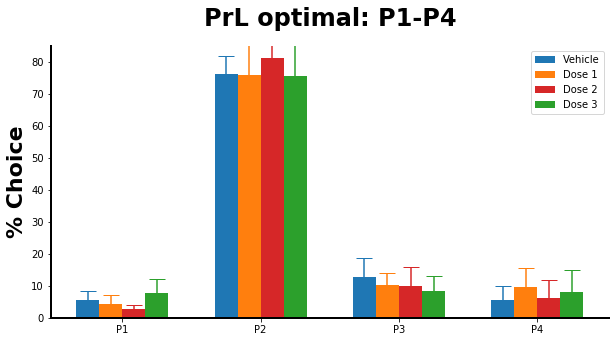

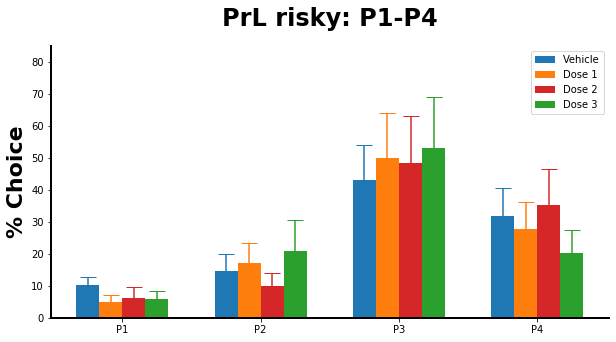

In [20]:
ls_bar_plot('PrL optimal',group_means_risk,sem_risk)
ls_bar_plot('PrL risky',group_means_risk,sem_risk)

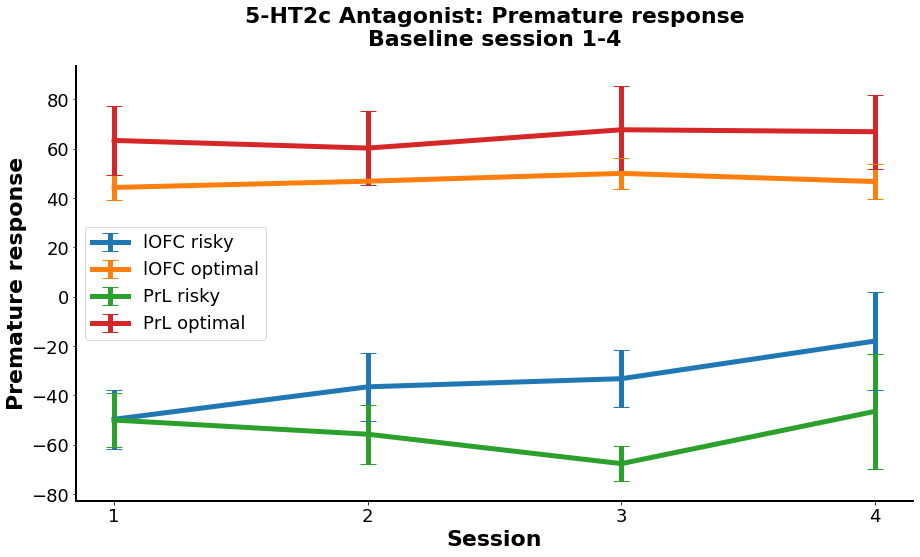

In [13]:
rgt_plot('risk',1,4,group_names_risk,'5-HT2c Antagonist',group_means_risk,sem_risk,var_title = 'Premature response')

In [175]:
export_to_excel(df1,groups,'brain region','..\\PhD_data\\BH06\\BH06_all-data2.xlsx')

In [89]:
export_to_excel(df1,groups,'brain region', '..\\PhD_data\\BH06\\BH06_all-data_asin.xlsx', asin = True)

In [20]:
figure_group = 'lOFC risky'
veh_means =  list(group_means_risk.loc[figure_group,[col for col in group_means_risk.columns if col.startswith('1')]])
dose1_means = list(group_means_risk.loc[figure_group,[col for col in group_means_risk.columns if col.startswith('2')]])
dose2_means = list(group_means_risk.loc[figure_group,[col for col in group_means_risk.columns if col.startswith('3')]])
dose3_means = list(group_means_risk.loc[figure_group,[col for col in group_means_risk.columns if col.startswith('4')]])

print(veh_means)
print(dose1_means)
print(dose2_means)
print(dose3_means)

[1.8375726300254602, 23.32347126726058, 66.918943201569, 7.920012901144976]
[2.9491198456715697, 28.790505697544475, 57.71210578146421, 10.548268675319738]
[4.698057405905315, 28.694981903647015, 53.98062723941755, 12.626333451030114]
[9.302336550374156, 31.721784152492873, 47.563128227687805, 11.412751069445168]


In [22]:
veh_sem =  list(sem_risk.loc[figure_group,[col for col in sem_risk.columns if col.startswith('1')]])
dose1_sem = list(sem_risk.loc[figure_group,[col for col in sem_risk.columns if col.startswith('2')]])
dose2_sem = list(sem_risk.loc[figure_group,[col for col in sem_risk.columns if col.startswith('3')]])
dose3_sem = list(sem_risk.loc[figure_group,[col for col in sem_risk.columns if col.startswith('4')]])

print(veh_sem)
print(dose1_sem)
print(dose2_sem)
print(dose3_sem)


[0.6692817596888938, 5.801700415320504, 9.816291217200602, 5.606609571921169]
[1.1249726056326377, 7.015179463434053, 9.852024916768007, 5.889966213724503]
[1.716143615969956, 5.069563404860061, 9.539469880073012, 5.88546432597273]
[4.19845081416456, 8.167160241860365, 11.107145174236772, 5.205480288334645]


In [27]:
print(df1.loc[lOFC_optimal,'omit1'], df1.loc[lOFC_optimal,'omit4'])

2     0.0
4     5.0
6     1.0
12    6.0
14    1.0
16    7.0
25    0.0
26    1.0
32    3.0
Name: omit1, dtype: float64 2     1
4     2
6     0
12    0
14    0
16    0
25    0
26    1
32    0
Name: omit4, dtype: int64


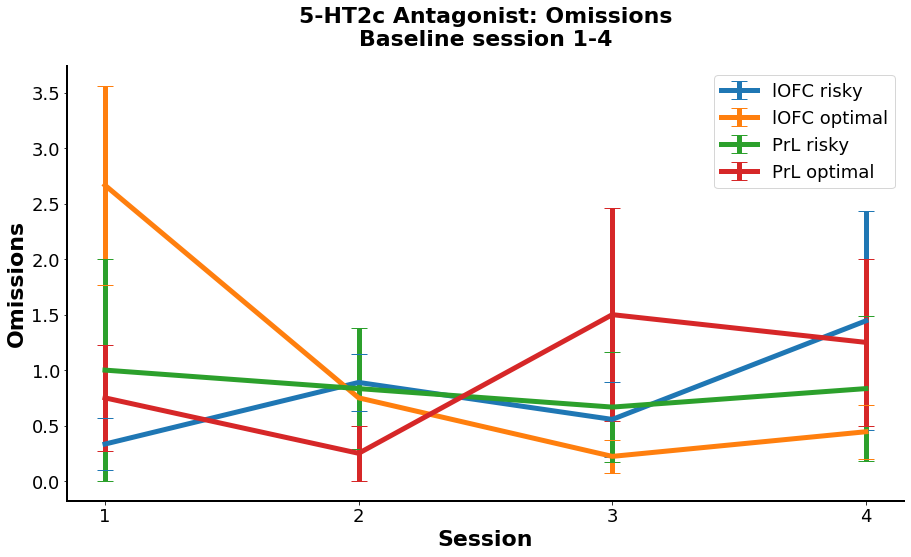

In [29]:
rgt_plot('omit',1,4,group_names_risk,'5-HT2c Antagonist',group_means_risk,sem_risk,var_title = 'Omissions')